In [690]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

## Read the dataset

In [691]:
df = pd.read_csv('../data/nepse_data.csv')

In [692]:
df.head()

,S.N.,Open,High,Low,Close,Change,Per Change(%),Turnover,Date
0,1,"2,075.62","2,076.84","2,055.82","2,062.03",-14.46,-0.69,"3,869,118,741.97",2024-02-15
1,2,"2,071.71","2,081.56","2,064.85","2,076.50",5.91,0.28,"4,252,722,895.25",2024-02-14
2,3,"2,101.54","2,101.54","2,065.14","2,070.59",-30.56,-1.45,"4,667,179,304.13",2024-02-13
3,4,"2,085.81","2,103.56","2,081.99","2,101.16",15.33,0.73,"3,586,984,128.47",2024-02-12
4,5,"2,101.27","2,108.73","2,083.76","2,085.82",-10.50,-0.50,"4,085,678,472.16",2024-02-11


Here, we will be using the closing price to train our model.<br>
So, lets remove all the other columns except for Close and Date

In [693]:
df.columns

Index(['S.N.', 'Open', 'High', 'Low', 'Close', 'Change', 'Per Change(%)',
       'Turnover', 'Date'],
      dtype='object')

In [694]:
df.drop(columns=["S.N.", "Open", "High", "Low", "Change", "Per Change(%)", "Turnover"], inplace=True)

In [695]:
df.head()

,Close,Date
0,"2,062.03",2024-02-15
1,"2,076.50",2024-02-14
2,"2,070.59",2024-02-13
3,"2,101.16",2024-02-12
4,"2,085.82",2024-02-11


In [696]:
df.dtypes

Close    object
Date     object
dtype: object

As we can see above the "Close" attribute has object type.<br>
So, we need to convert it to float value 

Also, the values are comma seperated(2,064.32, 10,342). So first we need to remove those commas before converting it into float type

In [697]:
def remove_comma(val: str):
    return val.replace(",", "")

In [698]:
df["Close"] = df["Close"].apply(remove_comma)

Now, we convert the type of Close cloumn from object type to float type 

In [699]:
df["Close"] = pd.to_numeric(df["Close"])

Additionally, let us also set the type of Date column to Datetime

In [700]:
df["Date"] = pd.to_datetime(df["Date"])

In [701]:
df.dtypes

Close           float64
Date     datetime64[ns]
dtype: object

In [702]:
df.head()

,Close,Date
0,2062.03,2024-02-15
1,2076.50,2024-02-14
2,2070.59,2024-02-13
3,2101.16,2024-02-12
4,2085.82,2024-02-11


### NICE

Now, lets look at how the price of NEPSE changed over time 

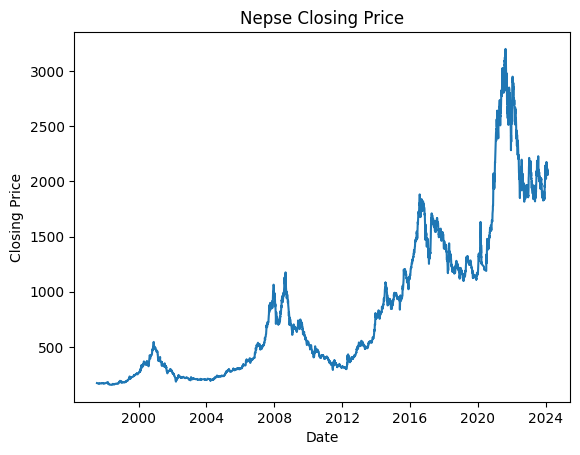

In [703]:
plt.plot(df['Date'], df['Close'])
plt.title("Nepse Closing Price")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

From the above graph, we see that the price started at around Rs. 200 from the 90s and has reached a maximum peak of around Rs. 3300 at somewhere around 2022.

Because we will be performing univariate time series forecasting of the Closing price. We will be using the temporal variation of the closing price to train our model.

This might result in a constrating variations in our dataset.<br>
To prevent this, and also to prevent instability in our model during model, we will first scale our data to be between 0 and 1 using the Min-Max Scaler.<br><br>
For each $X$ in the Close cloumn:

$$X_{scaled} = \frac{X-X_{min}}{X_{max}-X_{min}}$$
where, $X_{min}$ and $X_{max}$ are the smallest and the largest values in the Close cloumn respectively


In [704]:
df["Close"].describe()

count    6109.000000
mean      850.485962
std       702.804490
min       156.430000
25%       297.490000
50%       531.960000
75%      1247.300000
max      3198.600000
Name: Close, dtype: float64

In [705]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [706]:
df.head()

,Close,Date
0,2062.03,2024-02-15
1,2076.50,2024-02-14
2,2070.59,2024-02-13
3,2101.16,2024-02-12
4,2085.82,2024-02-11


In [707]:
df.tail()

,Close,Date
6104,172.66,1997-07-24
6105,173.03,1997-07-23
6106,173.03,1997-07-22
6107,173.25,1997-07-21
6108,173.26,1997-07-20


Our dataset goes from 2024 to 1997.<br>
We will be using historical data to predict the future, so lets reverse our dataset so that it goes from 1997 to 2024

In [708]:
df = df.iloc[::-1]

In [709]:
df.head()

,Close,Date
6108,173.26,1997-07-20
6107,173.25,1997-07-21
6106,173.03,1997-07-22
6105,173.03,1997-07-23
6104,172.66,1997-07-24


In [710]:
df.tail()

,Close,Date
4,2085.82,2024-02-11
3,2101.16,2024-02-12
2,2070.59,2024-02-13
1,2076.50,2024-02-14
0,2062.03,2024-02-15


Before scaling our data, we will first split the data into train and test set.<br>
Then we'll fit our scaler onto the training set and use it to transform our test set.<br>
Why??
<a href="https://stackoverflow.com/questions/66489965/can-i-use-standardscaler-on-whole-data-set-or-should-i-calculate-on-train-and">Have a read </a>

We will split our data such that we will have 80% of the total data in our training set and the remanining 20% in our test set

In [711]:
len(df["Close"])

6109

In [712]:
len(df["Close"]) * 0.8

4887.2

In [713]:
df_train = df.iloc[:4887]
df_test = df.iloc[4888:]

In [714]:
df_train.shape, df_test.shape

((4887, 2), (1221, 2))

In [715]:
df_train["Close"].shape

(4887,)

Our data is a 1D array, however, the scaler takes in a Matrixlike object as input. So we need to convert our array of elements into array of array of elements

For eg:

In [716]:
d = np.random.randn(5)
print("Original Shape: ")
print(d.shape)
print("Original 1D Data: ")
print(d)
print("New shape after reshaping: ")
print(d.reshape(-1, 1).shape)
print("Reshaped 2D Data: ")
print(d.reshape(-1, 1))

Original Shape: 
(5,)
Original 1D Data: 
[ 0.04434932 -1.02060845 -0.67323334  0.66257182 -1.65727351]
New shape after reshaping: 
(5, 1)
Reshaped 2D Data: 
[[ 0.04434932]
 [-1.02060845]
 [-0.67323334]
 [ 0.66257182]
 [-1.65727351]]


In [717]:
scaler.fit(np.array(df_train["Close"]).reshape(-1, 1))
scaled_train = scaler.transform(np.array(df_train["Close"]).reshape(-1, 1))
scaled_test = scaler.transform(np.array(df_test["Close"]).reshape(-1, 1))

Now that we have scaled our data, we will need to convert our single target variable into target and predictor variables.  

To do this, we will set the first n values as our predictor variables and the n+1 th value as the target variable meaning we will use historical data of previous n days to predict the price current day price.<br><br>
Finally, our dataset will be of the form:<br><br>
t-n | ... | t-9 | t-8 | t-7 | t-6 | t-5 | t-4 | t-3 | t-2 | t-1 | t<br><br>
where, t will now be the tagret variable and rest will be the predictor variables

In [718]:
import pandas as pd
import numpy as np

def create_timeseries_dataset(data, sequence_length=5):
    column_names = []
    for i in range(sequence_length, 0, -1):
        column_names.append(f"t-{i}")
    column_names.append("t")
    df_timeseries = pd.DataFrame(columns=column_names)
    
    for index in range(len(data)):
        # Terminate the iteration until we reach index sequence_length - 1
        # Until index sequence_length - 1, we don't have enough data to create the timeseries dataset
        if(index < sequence_length):
            continue
        new_row = {}
        for i in range(sequence_length, 0, -1):
            new_row[f"t-{i}"] = data[index-i][0]
        new_row["t"] = data[index][0]        
        
        df_timeseries.loc[len(df_timeseries)] = new_row
        
    return df_timeseries

In [719]:
sequence_length = 64

In [720]:
X_y_train = create_timeseries_dataset(scaled_train, sequence_length=sequence_length)
X_y_test = create_timeseries_dataset(scaled_test, sequence_length=sequence_length)

In [721]:
X_y_train.shape, X_y_test.shape

((4823, 65), (1157, 65))

Now lets seperate the depenedent(predictor) and independent(target) variables

In [722]:
X_train = X_y_train.drop(columns=["t"])
y_train = X_y_train["t"]
X_test = X_y_test.drop(columns=["t"])
y_test = X_y_test["t"]

In [723]:
X_train.shape, y_train.shape

((4823, 64), (4823,))

In [724]:
X_test.shape, y_test.shape

((1157, 64), (1157,))

X_train and X_test must have a 3D shape: (batch_size, no_of_columns, 1) so lets rehsape it

In [725]:
X_train = X_train.to_numpy().astype(np.float32)
X_test = X_test.to_numpy().astype(np.float32)

In [726]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [727]:
X_train.shape, X_test.shape

((4823, 64, 1), (1157, 64, 1))

In [728]:
import tensorflow as tf

In [729]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(sequence_length,1)))
model.add((tf.keras.layers.LSTM(32, return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.2))
model.add((tf.keras.layers.LSTM(16, return_sequences=False)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 64, 32)            4352      
                                                                 
 dropout_47 (Dropout)        (None, 64, 32)            0         
                                                                 
 lstm_49 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_48 (Dropout)        (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 7505 (29.32 KB)
Trainable params: 7505 (29.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [730]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )

To prevent overfitting, we will use early stopping where we will monitor the validaton loss with a patience of 5

In [733]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [734]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[es])

Epoch 1/100
302/302 [==============================] - 11s 27ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1737
Epoch 2/100
302/302 [==============================] - 7s 24ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1433
Epoch 3/100
302/302 [==============================] - 7s 24ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1022
Epoch 4/100
302/302 [==============================] - 7s 24ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 5/100
302/302 [==============================] - 7s 24ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 6/100
302/302 [==============================] - 7s 24ms/step - loss: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 

Now lets look at how the loss(mse) and rmse for scaled input has eveloved over the epochs during training

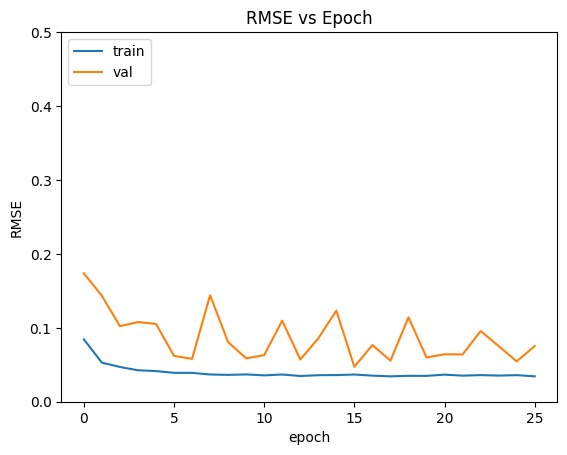

In [744]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('RMSE vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0, 0.5)
plt.show()

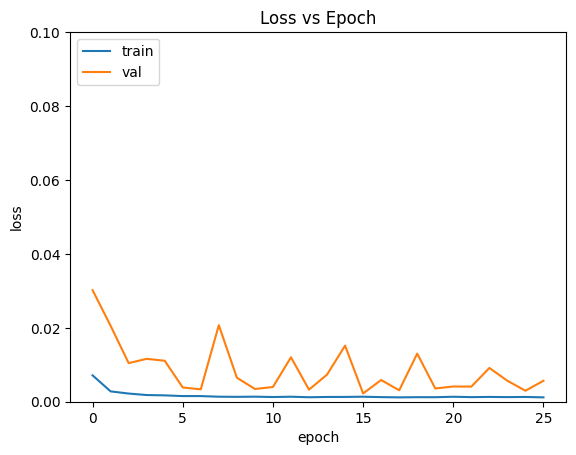

In [741]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0, 0.1)
plt.show()

Because we have scaled our dataset, we don't have a clear indication the metrics (mse, rmse).<br>
For this, lets use our model to predict the NEPSE price for both train and test set.

In [745]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

37/37 [==============================] - 0s 7ms/step


Now, we will convert these predictions back to the original scale using the inverse transform of the scaler.

In [746]:
train_preds = scaler.inverse_transform(train_preds)
test_preds = scaler.inverse_transform(test_preds)

Finally, we compute the mse and rmse for our model

In [747]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [748]:
print("For training set:")
print("MAE:", mean_absolute_error(y_train, train_preds))
print("MSE:", mean_squared_error(y_train, train_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_train, train_preds)))

For training set:
MAE: 591.6502348611422
MSE: 536346.2086924611
RMSE: 732.3566130598269


In [749]:
print("For test set:")
print("MAE:", mean_absolute_error(y_test, test_preds))
print("MSE:", mean_squared_error(y_test, test_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))

For test set:
MAE: 1924.1049958199771
MSE: 3969528.7991136913
RMSE: 1992.367636535409


Now lets look at our test prediction with respect to the original test prices

In [750]:
test_preds_plot = np.squeeze(test_preds, axis=1) 

In [751]:
test_preds_plot.shape

(1157,)

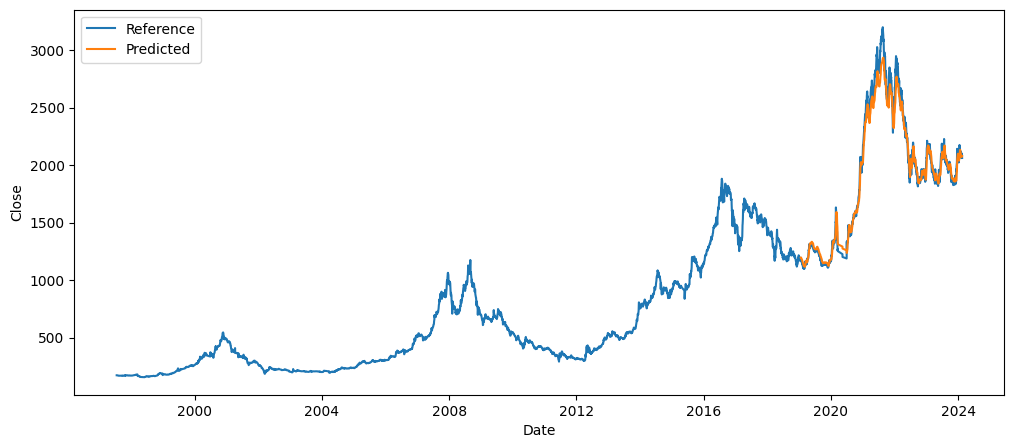

In [752]:
plt.figure(figsize=(12,5))
# plt.xlabel('Date')

ax1 = sns.lineplot(x="Date", y="Close", data=df, label="Reference")
# df_train.Close.plot(color='blue', grid=True, label='Count')
# ax2 = df_test.Close.plot(color='red', grid=True, secondary_y=True, label='Sum')
ax2 = sns.lineplot(x=list(df_test["Date"])[sequence_length:], y=test_preds_plot, label="Predicted")

plt.show()

While the result isn't an exact match, however, the model has learned the price pattern pretty well.<br>
For the test set we can see that the predicted price matches ups and downs of the original price with a small shift in price here and there.<br>

Since we now have a pretty good model, lets save it along with the scaler and timsetep length

In [753]:
import pickle

# save the model to a file
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open("nepse_timeseries_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [761]:
import json

In [766]:
with open("sequence_length.json", "w") as f: 
    json.dump({"sequence_length": sequence_length}, f)